Let's try some test samples from a separate file:
Sample with (width, height): (25.0, 32.0) classified as Pikachu
Sample with (width, height): (24.2, 31.5) classified as Pikachu
Sample with (width, height): (22.0, 34.0) classified as Pikachu
Sample with (width, height): (20.5, 34.0) classified as Pichu

It is your turn to enter sample values!


According to the algorithm, that is most likely a Pichu

Let's test the accuracy of the algorithm:


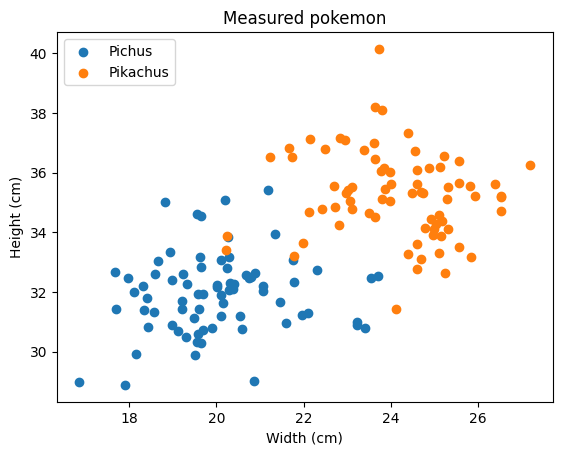

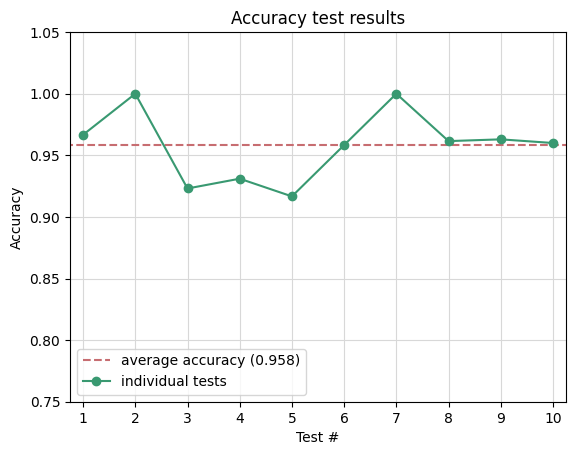

In [8]:
import math
import matplotlib.pyplot as plt
import statistics
import random



def get_pokemons():
    '''Returns dictionary of recognized pokemons.'''
    return {0: "Pichu", 1: "Pikachu"}



def pokemon_by_label(label):
    '''Returns pokemon name based on label.'''
    pokemons = get_pokemons()
    return pokemons[label]



def filtered_measurements(measurements, label):
    '''Returns measurements with matching label.'''
    filtered = []
    for measurement in measurements:
        if measurement["label"] == label:
            filtered.append(measurement)
    return filtered







def load_measurements(path, ignore_first_line = True):
    '''Parses and returns measurements from a file'''
    # Prepare for file not being at the right place and so on...
    try:
        with open(path) as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"load_measurements(): File not found '{path}'")
        return []
    except:
        print(f"load_measurements(): Unable to open file '{path}'")
        return []

    # remove "\n" at end of each line:
    lines = [line.rstrip() for line in lines]

    measurements = []

    # interpret data in each line as a measurement
    for line_number, line in enumerate(lines):
        # ignore first line (usually a heading) if told so
        if line_number == 0 and ignore_first_line:
            continue
        
        # tolerate (optional) spaces after commas:
        line.replace(", ", ",")

        # in case a line cannot be parsed, inform user 
        # and return no measurements at all
        try:
            line_data = line.split(", ")
            width = float(line_data[0])
            height = float(line_data[1])
            label = int(line_data[2])
        except:
            error_msg = ("load_measurements(): unable to parse data in " +
                         f"'{path}'  on line {line_number + 1}")
            print(error_msg)
            return[]
        
        measurement = {
            "width": width,
            "height": height,
            "label": label
        }
        measurements.append(measurement)
    
    return measurements


# This strange function only exists for generating parallel lists of
# x and y values for plotting graphs. Could probably be replaced to some
# function on numpyu
def widths_heights(measurements):
    '''Returns x and y values for plotting on graphs.'''
    widths = []
    heights = []
    for measurement in measurements:
        widths.append(measurement["width"])
        heights.append(measurement["height"])
    return {
        "widths": widths,
        "heights": heights
    }



def plot_measurements_graph(measurements):
    '''Plots measurements as points on a graph.'''
    # conveniently separated by unique index (0) from possible second graph 
    # generated by plot_accuracy_graph() 
    plt.figure(0)

    # plot points only of on class (pokemon species) at a time
    for label, pokemon in get_pokemons().items():
        filtered = filtered_measurements(measurements, label)

        # make filtered measurements into lists of x and y values for
        # points to be plotted:
        w_h = widths_heights(filtered)
        # we'll leave it to matplotlib to choose colors this time:
        plt.scatter(
            x = w_h["widths"],
            y = w_h["heights"],
            label = f"{pokemon}s" # in plural
        )

    # Add explanatory labels around graph:
    plt.title("Measured pokemon")
    plt.xlabel("Width (cm)")
    plt.ylabel("Height (cm)")

    # show a legend in upper left corner that explains 
    # which pokemon species each color represents
    plt.legend(loc="upper left")



def load_test_samples(path, ignore_first_line = True):
    '''Loads sample test points to be classified.'''
    # Prepare for file not being at the right place and so on...
    try:
        with open(path) as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"load_test_samples(): File not found '{path}'")
        return []
    except:
        print(f"load_test_samples(): Unable to open file '{path}'")
        return []

    # remove "\n" at end of each line:
    lines = [line.rstrip() for line in lines]

    samples = []

    # interpret data in each line as a measurement
    for line_number, line in enumerate(lines):
        # ignore first line (usually a heading) if told so
        if line_number == 0 and ignore_first_line:
            continue

        # tolerate (optional) spaces after commas:
        line.replace(", ", ",")

        # in case a line cannot be parsed, inform user 
        # and return sample test points at all
        try:
            # remove line numbering and parentheses
            cleaned_line = line[4:-1]
            #print(cleaned_line)
            line_data = cleaned_line.split(",")
            width = float(line_data[0])
            height = float(line_data[1])
        except:
            error_msg = ("load_test_samples(): unable to parse data in " +
                         f"'{path}'  on line {line_number + 1}")
            print(error_msg)
            return[]
        
        sample = {
            "width": width,
            "height": height
        }
        samples.append(sample)
        
    return samples


def test_sample(sample, measurements):
    '''Classifies a sample point and prints result in a line.'''
    width = sample["width"]
    height = sample["height"]
    label = classify_sample(sample, measurements)
    pokemon = pokemon_by_label(label)
    sample_msg = "Sample with (width, height): "
    sample_msg += f"({width}, {height}) classified as {pokemon}"
    print(sample_msg)


def calculate_distance(m1, m2):
    '''Calculates Eucidean (2-D) distance between two measurements.'''
    delta_x = m2["width"] - m1["width"]
    delta_y = m2["height"] - m1["height"]
    # the good old Pythegorean theorem:
    distance = math.sqrt(delta_x**2 + delta_y**2)
    return distance



def get_distance_value(a_dictionary):
    '''For .sort() of distance dictionaries.'''
    return a_dictionary["distance"]


# used for making classification bason on majority rule
def most_common_label(distances):
    '''Returns the most common label in a list of distances.'''
    # labels will become a list of labels, e.g. [0, 0, 1, 0, 1]
    labels = []
    for distance in distances:
        labels.append(distance["label"])

    # .mode() returns the label occuring the most in labels
    most_common = statistics.mode(labels)
    return most_common


# Classifies a sample point by finding the closest 11 classified measurements, 
# then deciding upon majority label of those 11:
def classify_sample(sample, measurements):
    '''Classifies a sample point based on already classified measurements'''
    # Will calculate the distances between the sample point and every 
    # classified measurement
    distances = []
    for measurement in measurements:
        distances.append({
            "label": measurement["label"],
            "distance": calculate_distance(sample, measurement)
        })
    
    # Find the closest points by sorting (ascending) and slicing
    distances.sort(key=get_distance_value)
    distances = distances[:11]
    # Note that we pick the closest 11 measurements, not 10, 
    # for a guaranteed majority desicion by most_common_label():
    return most_common_label(distances)

# Classifies a sample point just based on the label of the one closest 
# classified measurement. (The lab instructions asked for this solution to be 
# programmed and then replaced by a better one, see classify_sample())
def deprecated_classify_sample(sample, measurements):
    '''Not as accurate as classify_sample(). Nor recommended.'''
    shortest_distance = None
    closest_label = None

    for measurement in measurements:
        distance = calculate_distance(sample, measurement)
        if shortest_distance == None or distance < shortest_distance:
            shortest_distance = distance
            closest_label = measurement["label"]
    return closest_label


# Tests the accuracy by letting 50 randomly picked classified measurements 
# be treated as test points to be classified based on the remaining 100 
# measurements. 
def test_accuracy(measurements, tests = 10):
    '''Tests accuracy of algorithm with known measurements.'''
    # The accuracy of each test round will be store here:
    accuracies = []

    for test_index in range(tests):
        # create a temporary copy of measurements in order not to shuffle
        # the original list of measurements
        temp_measurements = measurements.copy()
        random.shuffle(temp_measurements)

        #divide into measurement for "training" and testing algorithm:
        training_measurements = temp_measurements[:100]
        test_measurements = temp_measurements[100:150]

        # Count outcomes
        # (See TP/FP/FN/TN table in lab instructions if you feel confused)
        true_positives = 0 # correct on predicting Pikachu
        false_positives = 0 # incorrent on prediciting Pikachu
        true_negatives = 0 # correct on predicting Pichu
        false_negatives = 0 # incorrect on predicting Pichu

        for test_measurement in test_measurements:
            predicted_label = classify_sample(test_measurement, training_measurements)
            actual_label = test_measurement["label"]
            if predicted_label == 1 and actual_label == 1:
                true_positives += 1
            elif predicted_label == 1 and actual_label == 0:
                false_positives += 1
            elif predicted_label == 0 and actual_label == 0:
                true_negatives += 0
            elif predicted_label == 0 and actual_label == 1:
                false_negatives += 0
        
        correct_predictions = true_positives + true_negatives
        all_predictions = correct_predictions + false_positives + false_negatives

        accuracy = correct_predictions / all_predictions
        accuracies.append(accuracy)

    return accuracies



def plot_accuracy_graph(accuracies):
    '''Plots accuracy test results on a graph.'''

    # conveniently separated by unique index (1) from possible previous graph 
    # generated by plot_measurements_graph()
    plt.figure(1)

    plt.title("Accuracy test results")
    plt.xlabel("Test #")
    plt.ylabel("Accuracy")
    
    # a rather subtle grey grid
    plt.grid(color="#d8d8d8")

    # first plot a (dashed) horizontal line representing average accuracy:
    average_accuracy = sum(accuracies) / len(accuracies)
    # stretach line acroos whole graph area
    x_values = [-1, len(accuracies) + 1]
    # repeated y value guaranteeing no slant
    y_values = [average_accuracy, average_accuracy]
    plt.plot(
        x_values,
        y_values,
        color = "#c76d71",
        linestyle = "dashed",
        # to be shown in graph legend:
        label = f"average accuracy ({average_accuracy:.3f})"
    )

    # plot the accuracy of each test round as markes with line inbetween
    x_values = list(range(1, len(accuracies) + 1))
    y_values = accuracies
    plt.plot(
        x_values,
        y_values,
        marker = "o",
        color = "#399971",
        label = "individual tests",
    )
    # make those "ticks" in x-axis match align with each marker
    # (the grid will adjust accordingly)
    plt.xticks(x_values)

    # set a proper visible area from graph
    plt.axis([0.75, len(accuracies) + 0.25, 0.75, 1.05])

    # show a legend in lower left corner explaining the markers 
    # and dashed line:
    plt.legend(loc="lower left")



def input_float(prompt = "Enter a floating point number: ", 
                accept_negative = True):
    '''Prompts user for a float number until a valid one is provided.'''
    while True:
        try:
            a_float = float(input(prompt))
        # if user enters a non-float value, keep asking again:
        except ValueError:
            print("Invalid input. Try again.")
        else:
            if not accept_negative and a_float < 0:
                print("Negative values not accepted. Try again.")
            else:
                return a_float



# A dictionary of measurement much used, thus the short variable name
mea = load_measurements("./datapoints.txt")

# first graph, hopefully visualizing some tendency of clustering for each class:
plot_measurements_graph(mea)

print("Let's try some test samples from a separate file:")
samples = load_test_samples("./testpoints.txt")
for sample in samples:
    test_sample(sample, mea)

# When previewing this Jupyter document on GitHub website, those 
# values to be entered might be mysteriously answered automatically...
print("\nIt is your turn to enter sample values!")
sample_data = {
    "width": input_float("Enter a width (in cm): ", accept_negative=False),
    "height":  input_float("Enter a height (in cm): ", accept_negative=False)
}
predicted_label = classify_sample(sample_data, mea)
print(f"According to the algorithm, that is most likely a {pokemon_by_label(predicted_label)}")

# The bonus tasks:
print("\nLet's test the accuracy of the algorithm:")
# test the accuracy 10 times (each time with different random data points)
accuracies = test_accuracy(mea, 10)

# second graph, visualizing accuracy test results:
plot_accuracy_graph(accuracies)